# Improving Policy Gradients with a baseline


## The problem of the PG

Policy Gradient는 다음과 같습니다. (REINFORCE Method 참고)

$$ \nabla_{\theta} J(\theta) =  \sum^{T}_{t=1} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) \cdot R_t $$

1. PG는 게임이 끝날때까지 기다린 다음에 모델을 학습 가능 -> 학습 속도 저하
2. Cumulative reward를 사용하기 때문에 0이 될 수도 있음 -> Good actions 그리고 Bad actions 이 서로 상쇄해서 0값 -> 학습 안됨 
3. Cumulative reward를 사용하기 때문에 특정 bad actions 또는 good actions을 학습하지 못함 (good actions이 많은 경우 bad actions을 압도함)




## Reducing variance

결론적으로 $ R_t $ 가 너무 큰 값이 들어오거나 작은 값이 들어오거나, stable하지 않아서 생기는 문제를 해결하는 방법으로 <br>
cumulative reward를 baseline으로 빼줌으로서 조금더 reward를 stable하게 만들어 줍니다.

$$ \nabla_{\theta} J(\theta) =  \sum^{T}_{t=1} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) \cdot (R_t - b(s_t)) $$

직관적으로 보면 $ R_t - b(s_t) $ 를 해줌으로서 reward자체가 작아지게 되고, 당연히 gradient값도 작아지게 될 것입니다.<br>
예를 들어서 다음과 같다고 할때..

$$ \begin{align} 
\nabla_{\theta} \log \pi_{\theta}(a_t | s_t) &= [0.5, 0.2, 0.3] \\ 
R(t) &= [1000, 1001, 1002] \\ 
\nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot R(t) &= [0.5 \cdot 1000, 0.2 \cdot 1001, 0.3 \cdot 1002] 
\end{align} $$

해당값의 `np.var([0.5*1000, 0.2*1001, 0.3*1002]) = 15524.5` 이 나오게 됩니다. <br>
즉 상당히 큰 값의 variance값이 나오게 됩니다.

만약 baseline으로 $ R_t $ 에다가 1000을 빼주게 되면 다음과 같이 되게 될 것입니다.

$$ \begin{align} 
\nabla_{\theta} \log \pi_{\theta}(a_t | s_t) &= [0.5, 0.2, 0.3] \\ 
R(t) &= [0, 1, 2] \\ 
\nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot R(t) &= [0.5 \cdot 0, 0.2 \cdot 1, 0.3 \cdot 2] \\
&= 23286.8
\end{align} $$

`np.var([0.5 * 0, 0.2*1, 0.3*2]) = 0.062` 값이 나옵니다.<br>
즉 작은 gradient값이 나오게 되고 stable한 학습이 가능해집니다.

## Common Baseline Functions

결론적으로 baseline이라는 것은 기본적으로 reward에 대한 기대값을 빼줌으로서 variance값을 낮추는 것이 목표입니다.

$$ \begin{align} \nabla_{\theta} J(\theta) &= \nabla_{\theta} \log \pi_{\theta} (s, a) \cdot R_t & \text{REINFORCE} \\ 
&= \nabla_{\theta} \log \pi_{\theta} (s, a) \cdot Q_{w} (s, a) & \text{Q Actor-Critic} \\
&= \nabla_{\theta} \log \pi_{\theta} (s, a) \cdot A_{w} (s, a) & \text{Advantage Actor-Critic} \\
&= \nabla_{\theta} \log \pi_{\theta} (s, a) \cdot \delta & \text{TD Actor-Critic} \\
\end{align}$$



# Advantage Actor Critic Method

## A2C Forward

Advantage Actor Critic Method는 다음과 같습니다.

$$ \begin{align} \nabla_{\theta} J(\theta) &\sim \sum^{T-1}_{t=0} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) \left(r_{t+1} + \gamma V_v(s_{t+1}) - V_v(s_t) \right)  \\
&= \sum^{T-1}_{t=0} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) A(s_t, a_t)
\end{align} $$

* $ A(s_t, a_t) $ : Advantage Function
* Policy Model: actor model은 현재 state를 보고 **그 다음 action** $ a_{t+1} $ 을 예측합니다.
* Value Model: value model은 현재 state를 보고 **그 다음 value** $ r_{t+1} $ 를 예측 합니다.
* $ r_{t+1}  = R(s, a) $ : 즉 model(state)를 해서 나온 value값 입니다.
* $ \left(r_{t+1} + \gamma V_v(s_{t+1}) - V_v(s_t) \right) $ : TD Error

위의 공식에 대한 설명은 다음과 같습니다.<br>
아래는 **Advantage Function** 입니다.

$$ A(s_t, a_t) = Q_w(s_t, a_t) - V_v (s_t) $$


* $ Q_w(s_t, a_t) $ : Q value for an action a in state s
* $ V(s) $ : **average value of that state**

V function을 baseline function으로 사용함으로서, Q value - V value 를 하게 됩니다. <br>
즉, **특정 action을 취하는 것이 일반적으로 기대할수있는 값보다 얼마나 더 좋을가를 나타내는 것입니다**.  <br>
해당 action이 해당 state에서 평균적인 action보다 얼마나 더 좋냐? 라고 물어보는 것과도 같습니다.

Q value 그리고 V value를 각각 따로 뉴럴 네트워크를 만들필요는 없습니다. (policy network까지 더 추가해서..)<br>
Bellmal optimality equation을 사용해서 효율적으로 만들 수 있습니다.

$$ Q(s_t, a_t) = \mathbb{E} \left[ r_{t+1} + \gamma V(s_{t+1}) \right] $$

따라서 1-step Advantage 는 다음과 같이 정의할 수 있습니다. 

$$  A(s_t, a_t) = r_{t+1} + \gamma V_v(s_{t+1}) - V_v(s_t) $$


## Training Model

Policy Update 는 다음과 같이 합니다.

$$ \partial\theta_{\pi} = \partial\theta_{\pi} + \nabla_{\theta} \log \pi_{\theta} (a_i | s_i) (R -V_{\theta}(s_i)) $$ 

Value

# Temporal Difference

## TD(1)

궁극적으로 Monte Carlo, REINFORCE와 동일하게 episode가 끝날때까지 기다린다음에 update가 가능합니다.

$$ \begin{align} 
V(s_t) &= V(s_t) + \alpha(G_t - V(s_t)) \\
G_t &=  r_{t+1} + \gamma r_{t+2} + \gamma r_{t+3} + ... + \gamma^{T-1}r_T
\end{align} $$

* $ T $ : Terminal 

## TD(0)

TD(1)에서는 episode가 끝날때까지의 sum of discounted rewards $ G_t $ 를 사용했었습니다. <br>
TD(0)의 경우는 바로 앞단계 1-step reward $ r_{t+1} $ 만 보게 됩니다.

$$ V(s_t) = V(s_t) + \alpha(r_{t+1} + \gamma V(s_{t+1}) - V(s_t) ) $$

## TD(λ) :: Semi Gradient TD

TD(0) 와 TD(1) 의 장단점을 합쳐놓은 것이 TD(λ) 입니다. <br>
N-Step Bootstrapping이라고도 하며 N 개의 rewards를 사용해서 업데이터를 합니다. <br>
문제는 여러개의 rewards가 있는데 어떻게 credit assignment를 할 것인지 입니다. <br>
여기에서 사용하는 방법이 Eligibility Traces (ET) 라고 하며,<br>
기본적인 방법은 **Recency** 그리고 **Frequency** 에 따라서 credit assignment를 합니다.


$$ z_0 = 0 $$
$$ E_t(s) = \gamma \lambda E_{t-1}(s) + 1 (s_t = s) $$


알고리즘은 다음과 같습니다. 


Loop for each episode: 
    Initialize S
    z = 0
    Loop for each step of episode:
        Choose $ A $


# N-Step Boostrapping

## Background (MC and TD)

Monte Carlo (MC)의 경우 에피소드가 끝날때가지 기다려야 하고, <br>
One-step temporal difference (TD)의 경우는 다로 다음 스텝까지만 기다리면 됩니다. 

$$ \begin{align} 
\text{MC | } TD(1) &= V(S_t) = V(S_t) + \alpha \left[ G_t - V(S_t) \right]  \\
 TD(0) &= V(S_t) = V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right]
\end{align} $$ 




1. Monte Carlo
  * 장점: 특정 state에 bias가 줄어든다 
  * 단점: high variance 문제를 겪을 수 있으며, 에피소드가 끝날때 까지 기다려야 하기 때문에 느리다
2. Temporal Difference 
  * 장점: low variance 이며, 다음 스텝 까지만 보기 때문에 효율적이다 
  * 단점: 최초에 값이 매우 부정확하거나, 특정 state에 대한 bias가 심하다

## N-Step Bootstrapping

MC 와 TD의 장점을 서로 합친 개념입니다.

Q function은 대략 다음과 같습니다.

$$ \begin{align}
Q_{\pi} &= \mathbb{E} \left[ r_0 + \gamma r_1 + \gamma^2 r_2 + ... + \gamma^T r_T \right] & \text{Monte Calro} \\
&= \mathbb{E} \left[r_0 + \gamma V_{\pi}(s_1) \right] & \text{1-step TD} \\
&= \mathbb{E} \left[r_0 + \gamma r_1 +  \gamma^2 V_{\pi}(s_2) \right] & \text{2-step TD} \\ 
&= \mathbb{E} \left[r_0 + \gamma r_1 + \gamma^2 r_2 + \gamma^3 r_3 + ... + \gamma^n V_{\pi}(s_n) \right] & \text{n-step TD} \\
\end{align} $$

**Monte Carlo**

$$ G_t = =  R_{t+1} + \gamma R_{t+2} + \gamma^2  R_{t+3} + ... + \gamma^{T-t-1}R_T $$

**TD**

$$ G_{t:t+1} = = R_{t+1} + \gamma V_t(S_{t+1}) $$

**2-Step return**

$$ G_{t:t+1} = = R_{t+1} +  \gamma R_{t+2} + \gamma^2 V_t(S_{t+2}) $$

**n-step return**

$$ G_{t:t+n} = = R_{t+1} +  \gamma R_{t+2} + ... +  \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n}) $$


![](images/actor-critic-n-step.png)




## N-Step Implementation

N-Step 의 이슈중에 하나는 $ t $ 라는 현재시점 $ s_t $ 에서  $ a_t $ 을 취했을때 나오는 <br>
$ \text{next_reward} = r_{t+1} $ 그리고 $ \text{next_state} s_{t+1} $ 밖에 모르는 상황입니다. 

쉽게 코드로 설명하면 다음과 같습니다. 

```
next_state, next_reward, done, info = env.step(action_t)
```

문제는 N-Step을 구현하기 위해서는 미래시점의 rewards 들이 필요합니다. <br>
즉 이런 것들.. $ r_{t+2}, r_{t+3}, ..., r_{t+n}, s_{t+n} $ 

따라서 구현상에서는 **time windows of size n 의 크기로 states, actions, 그리고 rewards들을 저장**해놓습니다.<br>
그리고 학습시에는 $ V_{\pi} (S_{t-n}) $ 즉 t-n 시점으로 돌아가서 학습을 할 수 있습니다.




# Generalized Advantage Estimation (GAE)

## Infinite Geometric Series Formula

[칸 아카데미의 Infinite Geometric Series Formula Intuition](https://www.khanacademy.org/math/ap-calculus-bc/bc-series-new/bc-series-optional/v/deriving-geometric-series-sum-formula) 을 참고 합니다.

아래의 공식은 GAE 수식 도출에 참고해야 합니다.


$$ \begin{align} \sum^\infty_{k=0} = S_{\infty} &= \alpha r^0 + \alpha r^1 + \alpha r^2 + \alpha r^3 + ... + \alpha r^\infty \\
r S_{\infty} &= \alpha r^1 + \alpha r^2 + \alpha r^3 + \alpha r^4 + ... + \alpha r^\infty \\
S_{\infty} - r S_{\infty} &= \alpha \cdot 1 \\
S_{\infty} (1-r) &= \alpha \\
S_{\infty} &= \frac{\alpha}{1-r}
\end{align} $$
 
아래 GAE에서 다시 설명하지만 $ (1-\alpha) $ 를 TD에다가 곱하게 됩니다. <br>
이경우 아래와 같이 모두 합한 값이 1이 되게 만들려고 하는 의도 입니다.

$$ (1-r) \cdot \frac{\alpha}{1-r} = \alpha $$

In [50]:
lambda_ = 0.95

print('sum method   :', sum([lambda_**i for i in range(1000)]))
print('approximation:', 1 / (1-lambda_))

sum method   : 19.999999999999982
approximation: 19.999999999999982


## Generalized Advantage Estimation ( $ \lambda - \text{return} $ )

Monte carlo의 경우 episode가 끝날때까지 기다려야 하기 때문에 학습 속도에 있어서 문제가 있으며, <br>
1-step temporal difference learning의 경우 속도는 빠르지만 bias한 것이 문제가 될 수 있습니다.<br>
그래서 N-Step Learning이 나오게 되었지만, 역시 여전히 최적의 n값을 지정하는 것은 다시 문제가 될 수 있습니다. 

$ TD(\lambda) $ 는 이러한 문제를 해결하기 위해서 나온 알고리즘입니다. <br>
기본적인 아이디어는 단 하나의 최적의 n값을 사용하는것이 아니라 모든 가능한 n-step TD의 weighted sum을 적용하는 것입니다. 

먼저 advantage function을 정의하면 다음과 같습니다. <br>

$$ \text{advantage function} = A(s_t, a_t) = r_t + \gamma V(s_{t+1}) - V(s_t)  $$


n-step에 따라서 advantage function의 모습은 다음과 같이 변합니다.


$$ \begin{align} 
& A^{(1)}_t = \delta_t &  &= r_t + \gamma V(s_{t+1}) - V(s_t) \\
& A^{(2)}_t = \delta_t + \gamma \delta_{t+1} &  &= r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+2}) - V(s_t) \\
& A^{(3)}_t = \delta_t + \gamma \delta_{t+1} + \gamma ^2 \delta_{t+2} &  &= r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 V(s_{t+3}) - V(s_t)
\end{align} $$


최종적으로 Generalized Advantage Estimation (GAE) 는 exponentially-weighted average of n-step estimators 로 정의가 될 수 있습니다. <br>


$$
\begin{align}
A_t^{GAE(\gamma,\lambda)} &= (1-\lambda)\Big(A_{t}^{(1)} + \lambda A_{t}^{(2)} + \lambda^2 A_{t}^{(3)} + \cdots \Big) \\
&= (1-\lambda)\Big(\delta_t^V + \lambda(\delta_t^V + \gamma \delta_{t+1}^V) + \lambda^2(\delta_t^V + \gamma \delta_{t+1}^V + \gamma^2 \delta_{t+2}^V)+ \cdots \Big)  \\
&= (1-\lambda)\Big( \delta_t^V(1+\lambda+\lambda^2+\cdots) + \gamma\delta_{t+1}^V(\lambda+\lambda^2+\cdots) + \cdots \Big) \\
&= (1-\lambda)\left(\delta_t^V \frac{1}{1-\lambda} + \gamma \delta_{t+1}^V\frac{\lambda}{1-\lambda} + \cdots\right) \\
&= \sum_{l=0}^\infty (\gamma \lambda)^l \delta_{t+l}^{V}
\end{align} $$


* $ \lambda $ : 0 ~ 1 사이의 값
* $ GAE(\gamma, 0) $ : $ A_t = \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t) $
* $ GAE(\gamma, 1) $ : $ A_t = \sum^\infty_{j=0} \gamma^j r_{t+j} - V(s_t) $

즉 $ \lambda $ 값을  0로 맞추면 1-step TD가 되고, 1로 맞추면 Monte Carlo가 되며, <br>
이 두가지를 서로 섞었다고 볼 수 있습니다.



$$ G^{\lambda}_t = (1-\lambda) \sum^{\infty}_{i=1} \lambda^{i-1} G_{t:t+i} $$

뭐 이론적으로는 이런데.. 제가 생각하는 부분은 normalization부분이 크고, <br>
아주 쉽게 생각하면 그냥 gradient를 엄청나게 작게 줄여준다가 핵심일듯 합니다. 

$ (1 - \lambda) $ 를 곱하게 되는데, normalization과 같은 효과가 있습니다. <br>
만약 $ \lambda = 0.99 $ 라면 1 - 0.99 = 0.01 이 되기 때문에 쉽게 생각하면 gradient값이 상당하게 줄어듭니다. 




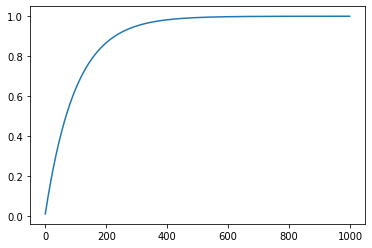

In [51]:
gamma = 0.99
s = 0
data = []
for i in range(1000):
    s += (1 - gamma) * gamma**i
    data.append(s)

sns.lineplot(range(1000), data)

https://medium.com/@violante.andre/simple-reinforcement-learning-temporal-difference-learning-e883ea0d65b0